<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Backtesing" data-toc-modified-id="Backtesing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Backtesing</a></span></li></ul></div>

In [1]:
%tensorflow_version 2.x
!git clone https://github.com/tensortrade-org/tensortrade.git
!pip install -U ta

TensorFlow 2.x selected.
Cloning into 'tensortrade'...
remote: Enumerating objects: 287, done.
remote: Counting objects: 100% (287/287), done.
remote: Compressing objects: 100% (201/201), done.
remote: Total 7670 (delta 188), reused 171 (delta 85), pack-reused 7383
Receiving objects: 100% (7670/7670), 53.96 MiB | 20.97 MiB/s, done.
Resolving deltas: 100% (5115/5115), done.
  Created wheel for ta: filename=ta-0.5.15-cp36-none-any.whl size=23439 sha256=1a825dfd41b8282243041c3fd15cbee7bfc5d824dfa6d7df4c8437b835793e88
  Stored in directory: /root/.cache/pip/wheels/53/b3/ec/93bd3d04147adcf06fab4ba9926b1150c987d8ffa053374709
Successfully built ta


In [2]:
cd tensortrade

/content/tensortrade


In [3]:
!pip install -r requirements.txt

     |████████████████████████████████| 276kB 2.8MB/s 
     |████████████████████████████████| 5.6MB 9.1MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44621 sha256=48c62b8ff4a26e3dad8fa0e7fa549206625c3f5c2778c6b1bb0c3421d9bfcc69
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Found existing installation: sympy 1.1.1
    Uninstalling sympy-1.1.1:
      Successfully uninstalled sympy-1.1.1


In [0]:
!mkdir /content/agents
!mkdir /content/data

In [0]:
import pandas as pd
import numpy as np
%matplotlib inline

import ta
from tensortrade.data import DataFeed, Module
from tensortrade.exchanges import Exchange
from tensortrade.exchanges.services.execution.simulated import execute_order
from tensortrade.data import Stream, DataFeed, Module
from tensortrade.instruments import USD, BTC, ETH, LTC
from tensortrade.wallets import Wallet, Portfolio
from tensortrade.environments import TradingEnvironment

from tensortrade.agents import DQNAgent
from tensortrade.agents import A2CAgent

In [8]:
import pandas as pd

def load_csv(filename):
    df = pd.read_csv(filename)
    # Convert the date column type from string to datetime for proper sorting.
    df['date'] = pd.to_datetime(df['date'])

    # Make sure historical prices are sorted chronologically, oldest first.
    df.sort_values(by='date', ascending=True, inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Format timestamps as you want them to appear on the chart buy/sell marks.
    df['date'] = df['date'].dt.strftime('%Y-%m-%d')

    # PlotlyTradingChart expects 'datetime' as the timestamps column name.
    df.rename(columns={'date': 'datetime'}, inplace=True)

    return df

df = load_csv('/content/data/hz_data.csv')
df.tail()

,datetime,open,high,low,close,volume,y2_hat
587,2019-10-19,7950.48,8096.76,7875.00,7960.49,3461.125292,0.003603
588,2019-10-20,7965.39,8314.77,7874.68,8235.74,6358.924991,0.003452
589,2019-10-21,8236.49,8352.00,8156.00,8213.65,4919.734168,0.000227
590,2019-10-22,8206.53,8314.77,7989.15,8025.90,5678.934831,-0.000325
591,2019-10-23,8021.57,8052.04,7920.40,7995.47,1588.417045,0.000585


In [0]:
import ta
from tensortrade.data import DataFeed, Module

dataset = ta.add_all_ta_features(df, 'open', 'high', 'low', 'close', 'volume', fillna=True)
dataset.head(3)

In [0]:
price_history = dataset[['datetime', 'open', 'high', 'low', 'close', 'volume']]  # chart data
display(price_history.head(3))

dataset.drop(columns=['datetime', 'open', 'high', 'low', 'close', 'volume'], inplace=True)

,datetime,open,high,low,close,volume
0,2018-03-11,8795.04,9768.37,8450.00,9535.04,16407.54238
1,2018-03-12,9535.04,9892.00,8742.07,9120.75,18751.02058
2,2018-03-13,9115.24,9482.79,8830.00,9142.32,16001.47535


In [0]:
from tensortrade.exchanges import Exchange
from tensortrade.exchanges.services.execution.simulated import execute_order
from tensortrade.data import Stream, DataFeed, Module
from tensortrade.instruments import USD, BTC, ETH, LTC
from tensortrade.wallets import Wallet, Portfolio
from tensortrade.environments import TradingEnvironment

coinbase = Exchange("coinbase", service=execute_order)(
    Stream("USD-BTC", price_history['close'].tolist())
)

portfolio = Portfolio(USD, [
    Wallet(coinbase, 10000 * USD),
    Wallet(coinbase, 10 * BTC),
])

with Module("coinbase") as coinbase_ns:
    nodes = [Stream(name, dataset[name].tolist()) for name in dataset.columns]

feed = DataFeed([coinbase_ns])
feed.next()

{'coinbase:/momentum_ao': 0.0,
 'coinbase:/momentum_kama': 9535.04,
 'coinbase:/momentum_mfi': 50.0,
 'coinbase:/momentum_roc': 0.0,
 'coinbase:/momentum_rsi': 100.0,
 'coinbase:/momentum_stoch': 82.30163004315938,
 'coinbase:/momentum_stoch_signal': 82.30163004315938,
 'coinbase:/momentum_tsi': 0.0,
 'coinbase:/momentum_uo': 50.0,
 'coinbase:/momentum_wr': -17.69836995684063,
 'coinbase:/others_cr': 0.0,
 'coinbase:/others_dlr': 0.0,
 'coinbase:/others_dr': 37.03698680179694,
 'coinbase:/trend_adx': 0.0,
 'coinbase:/trend_adx_neg': 0.0,
 'coinbase:/trend_adx_pos': 0.0,
 'coinbase:/trend_aroon_down': 4.0,
 'coinbase:/trend_aroon_ind': 0.0,
 'coinbase:/trend_aroon_up': 4.0,
 'coinbase:/trend_cci': 0.0,
 'coinbase:/trend_dpo': -2577.035287162161,
 'coinbase:/trend_ema_fast': 9535.04,
 'coinbase:/trend_ema_slow': 9535.04,
 'coinbase:/trend_ichimoku_a': 9109.185000000001,
 'coinbase:/trend_ichimoku_b': 9109.185000000001,
 'coinbase:/trend_kst': 370.3698680179695,
 'coinbase:/trend_kst_diff

In [0]:
env = TradingEnvironment(
    feed=feed,
    portfolio=portfolio,
    action_scheme='managed-risk',
    reward_scheme='risk-adjusted',
    window_size=20
)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning:

WARN: Box bound precision lowered by casting to float32



In [0]:
from tensortrade.agents import DQNAgent
agent = DQNAgent(env)
agent.train(n_episodes=10, n_steps=200, save_path="../agents/")

====      AGENT ID: 0d76af7d-78d9-432a-b3b1-c430b56229e0      ====
[2020-03-21 10:11:42 PM] Episode: 1/10 Step: 150/200
[2020-03-21 10:11:49 PM] Episode: 1/10 Step: 200/200
[2020-03-21 10:11:56 PM] Episode: 2/10 Step: 50/200
[2020-03-21 10:12:03 PM] Episode: 2/10 Step: 100/200
[2020-03-21 10:12:10 PM] Episode: 2/10 Step: 150/200
[2020-03-21 10:12:16 PM] Episode: 2/10 Step: 200/200
[2020-03-21 10:12:23 PM] Episode: 3/10 Step: 50/200
[2020-03-21 10:12:30 PM] Episode: 3/10 Step: 100/200
[2020-03-21 10:12:37 PM] Episode: 3/10 Step: 150/200
[2020-03-21 10:12:44 PM] Episode: 3/10 Step: 200/200
[2020-03-21 10:12:51 PM] Episode: 4/10 Step: 50/200
[2020-03-21 10:12:58 PM] Episode: 4/10 Step: 100/200
[2020-03-21 10:13:04 PM] Episode: 4/10 Step: 150/200
[2020-03-21 10:13:11 PM] Episode: 4/10 Step: 200/200
[2020-03-21 10:13:18 PM] Episode: 5/10 Step: 50/200
[2020-03-21 10:13:25 PM] Episode: 5/10 Step: 100/200
[2020-03-21 10:13:32 PM] Episode: 5/10 Step: 150/200
[2020-03-21 10:13:38 PM] Episode: 5/

911000.4083567932

In [0]:
# from tensortrade.agents import A2CAgent
# agent = A2CAgent(env)
# agent.train(n_episodes=4, n_steps=200, save_path="../agents/")

step
0      105350.400000
1      101976.384020
2      103704.154744
3       97550.631654
4      106953.327086
           ...      
196    101996.257209
197    100292.561614
198     98193.554290
199     98647.564485
200    101720.509873
Name: net_worth, Length: 201, dtype: float64


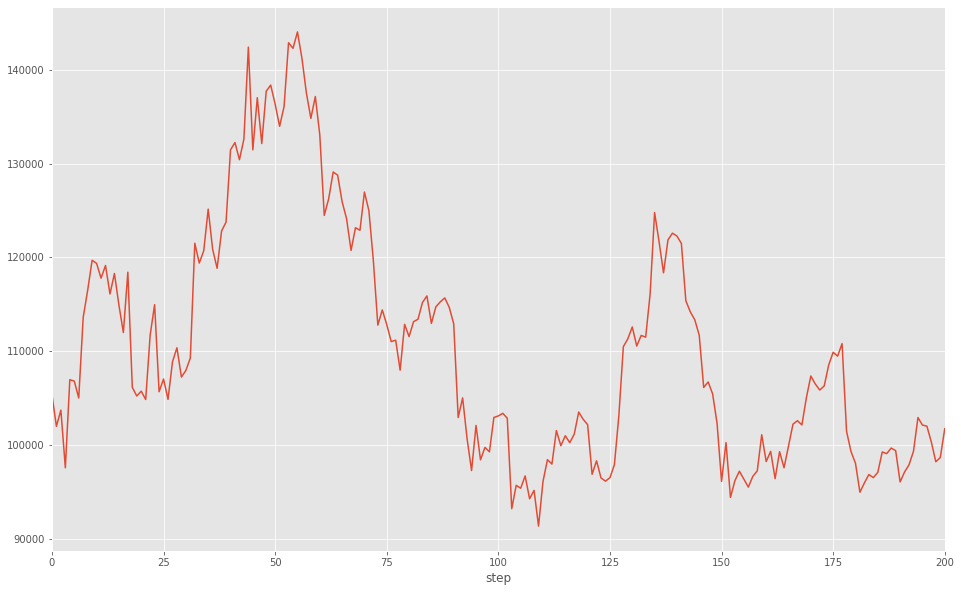

In [0]:
%matplotlib inline
print(portfolio.performance.net_worth)
portfolio.performance.net_worth.plot(figsize=(16,10))

## Backtesing

In [9]:
df1 = load_csv("/content/data/BTCUSD_1d.csv")
df1 = df1[1500:-600].reset_index(drop = True)
df1.tail()

,datetime,open,high,low,close,volume
858,2018-02-26,9595.99,10461.97,9376.34,10324.70,16156.805056
859,2018-02-27,10329.99,10850.00,10150.00,10566.30,10408.479938
860,2018-02-28,10572.49,11064.75,10255.07,10314.90,10490.749058
861,2018-03-01,10314.99,11090.00,10223.41,10903.13,9481.665146
862,2018-03-02,10917.37,11175.00,10774.01,11029.99,8329.097901


In [10]:
dataset1 = ta.add_all_ta_features(df1, 'open', 'high', 'low', 'close', 'volume', fillna=True)
dataset1.head(3)

/usr/local/lib/python3.6/dist-packages/ta/trend.py:543: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:547: RuntimeWarning:

invalid value encountered in double_scalars



,datetime,open,high,low,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,momentum_mfi,volume_em,volume_sma_em,volume_vpt,volume_nvi,volatility_atr,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,momentum_rsi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,others_dr,others_dlr,others_cr
0,2015-10-22,267.90,280.04,267.39,275.21,30166.425443,7130.246014,30166.425443,0.236364,0.000000,50.0,0.000000,0.000000,-27137.171080,1000.000000,0.0,275.210000,275.210000,275.210000,0.000000,0.000000,0.0,0.0,274.213333,286.863333,261.563333,9.226393,0.539394,0.0,0.0,275.21,275.21,1.0,1.0,0.000000,0.000000,0.000000,275.210000,275.210000,0.0,0.0,0.0,1.0,1.0,0.0,-89.022715,1.000000,0.000000,2470.627543,-899.771929,-899.771929,0.000000,273.715,273.715,2619.953082,2524.904009,4.0,4.0,0.0,275.21,-1.0,-1.00,0.0,0.0,100.0,0.0,50.0,61.818182,61.818182,-38.181818,0.0,275.21,0.0,-89.977193,0.000000,0.000000
1,2015-10-23,275.21,280.19,273.46,278.60,21572.268470,18509.377228,51738.693913,0.357747,73129.990115,50.0,97024.103092,97024.103092,-26877.178494,1012.317866,0.0,276.905000,280.295000,273.515000,2.448493,0.750000,0.0,0.0,275.815000,285.505000,266.125000,7.026449,0.643705,0.0,0.0,275.21,278.60,1.0,0.0,0.270427,0.054085,0.216342,275.731538,275.461111,0.0,0.0,0.0,1.0,1.0,0.0,0.002406,1.923694,66.666667,2468.932543,-899.154631,-899.463280,0.308649,273.790,273.790,2619.953082,2524.904009,8.0,4.0,4.0,278.60,-1.0,-1.00,0.0,0.0,100.0,100.0,50.0,87.578125,74.698153,-12.421875,0.0,278.60,0.0,1.231787,1.224262,1.231787
2,2015-10-24,278.60,284.00,278.22,282.84,20586.335018,30832.685041,72325.028931,0.426307,75152.285881,50.0,120309.418743,108666.760917,579.026763,1027.724283,0.0,278.883333,285.126075,272.640592,4.476956,0.816901,0.0,0.0,277.772222,286.158889,269.385556,6.038521,0.802133,0.0,0.0,275.21,282.84,1.0,0.0,0.817452,0.206759,0.610694,276.825148,276.007695,0.0,0.0,0.0,1.0,1.0,0.0,0.009324,2.784692,100.000000,2466.954210,-898.434147,-899.120236,0.686089,275.695,275.695,2619.953082,2524.904009,12.0,4.0,8.0,280.04,-1.0,280.04,0.0,1.0,100.0,100.0,50.0,93.016255,80.804187,-6.983745,0.0,282.84,0.0,1.521895,1.510431,2.772428


In [11]:
price_history1 = dataset1[['datetime', 'open', 'high', 'low', 'close', 'volume']]  # chart data
display(price_history1.head(3))

dataset1.drop(columns=['datetime', 'open', 'high', 'low', 'close', 'volume'], inplace=True)
dataset1['y2_hat']=np.nan

,datetime,open,high,low,close,volume
0,2015-10-22,267.90,280.04,267.39,275.21,30166.425443
1,2015-10-23,275.21,280.19,273.46,278.60,21572.268470
2,2015-10-24,278.60,284.00,278.22,282.84,20586.335018


In [12]:
coinbase = Exchange("coinbase", service=execute_order)(
    Stream("USD-BTC", price_history1['close'].tolist())
)

portfolio = Portfolio(USD, [
    Wallet(coinbase, 10000 * USD),
    Wallet(coinbase, 10 * BTC),
])

with Module("coinbase") as coinbase_ns:
    nodes = [Stream(name, dataset1[name].tolist()) for name in dataset1.columns]

feed = DataFeed([coinbase_ns])
feed.next()

env = TradingEnvironment(
    feed=feed,
    portfolio=portfolio,
    action_scheme='managed-risk',
    reward_scheme='risk-adjusted',
    window_size=20
)
agent = DQNAgent(env)
agent.restore(path="/content/agents/DQN1_10.hdf5")

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning:

WARN: Box bound precision lowered by casting to float32



In [16]:
state, reward, done, info = agent.env.step(action)
action = agent.env.action_space.sample()
n_steps = 200
step = 0

while not done and (step < n_steps):
    state, reward, done, info = agent.env.step(action)
    action = agent.get_action(state)
    print('step:', step, '-- action:', action)
    step += 1

step: 0 -- action: 84
step: 1 -- action: 84
step: 2 -- action: 84
step: 3 -- action: 84
step: 4 -- action: 84
step: 5 -- action: 84
step: 6 -- action: 84
step: 7 -- action: 84
step: 8 -- action: 84
step: 9 -- action: 84
step: 10 -- action: 84
step: 11 -- action: 84
step: 12 -- action: 84
step: 13 -- action: 53
step: 14 -- action: 84
step: 15 -- action: 70
step: 16 -- action: 41
step: 17 -- action: 45
step: 18 -- action: 41
step: 19 -- action: 41
step: 20 -- action: 41
step: 21 -- action: 41
step: 22 -- action: 84
step: 23 -- action: 20
step: 24 -- action: 84
step: 25 -- action: 84
step: 26 -- action: 84
step: 27 -- action: 84
step: 28 -- action: 84
step: 29 -- action: 84
step: 30 -- action: 84
step: 31 -- action: 84
step: 32 -- action: 53
step: 33 -- action: 84
step: 34 -- action: 20
step: 35 -- action: 53
step: 36 -- action: 84
step: 37 -- action: 84
step: 38 -- action: 84
step: 39 -- action: 84
step: 40 -- action: 84
step: 41 -- action: 84
step: 42 -- action: 84
step: 43 -- action: 8

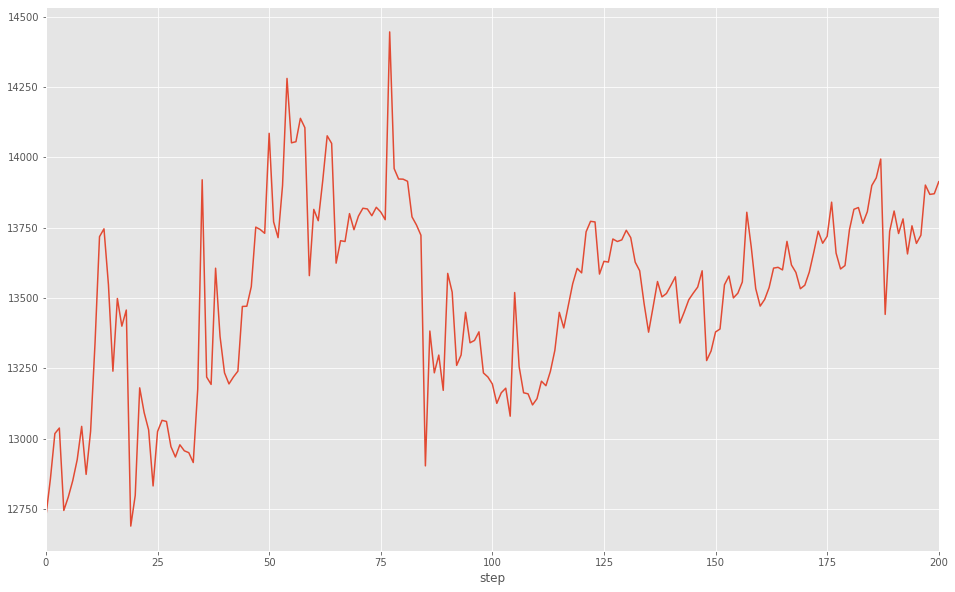

In [17]:
env.portfolio.performance.net_worth.plot(figsize=(16,10))